In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

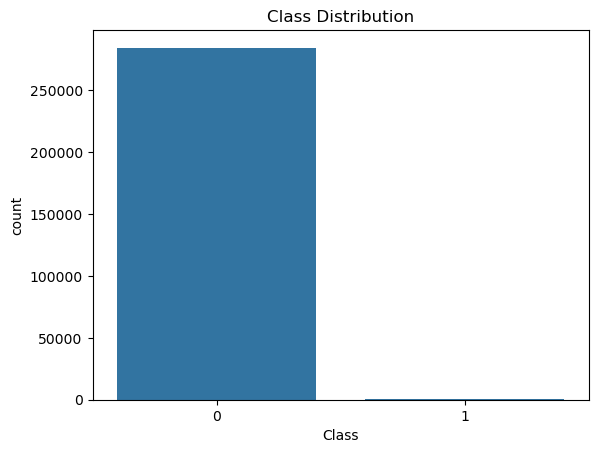

In [ ]:
# Load the dataset
df = pd.read_csv("creditcard.csv")
print(df.info())
print(df.describe())


print("Class distribution:")
print(df['Class'].value_counts())


sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()


In [ ]:

X = df.drop(['Class'], axis=1)
y = df['Class']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [ ]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Metrics:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     56863
           1       0.97      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726



c:\Users\atchu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:27:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



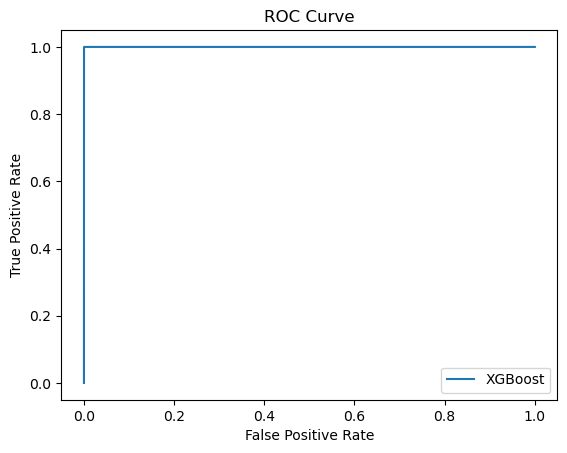

In [ ]:
# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Metrics:")
print(classification_report(y_test, y_pred_xgb))


fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_scaled)


y_pred_iso = iso_forest.predict(X_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)


print("Isolation Forest Metrics:")
print(confusion_matrix(y, y_pred_iso))


Isolation Forest Metrics:
[[281755   2560]
 [   203    289]]


In [ ]:
# Define Autoencoder
input_dim = X_scaled.shape[1]
autoencoder = Sequential([
    Dense(16, activation='relu', input_dim=input_dim),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=32, shuffle=True)


reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred_auto = np.where(mse > threshold, 1, 0)


print("Autoencoder Metrics:")
print(confusion_matrix(y, y_pred_auto))


Epoch 1/10


c:\Users\atchu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.7081
Epoch 2/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.5029
Epoch 3/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 945us/step - loss: 0.4687
Epoch 4/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 982us/step - loss: 0.4521
Epoch 5/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4474
Epoch 6/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4446
Epoch 7/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4459
Epoch 8/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4446
Epoch 9/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4396
Epoch 10/10
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 8s 902us/step - loss: 0.4428
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
Autoencoder Metrics:
[[270380  13935]
 [   186    306]]


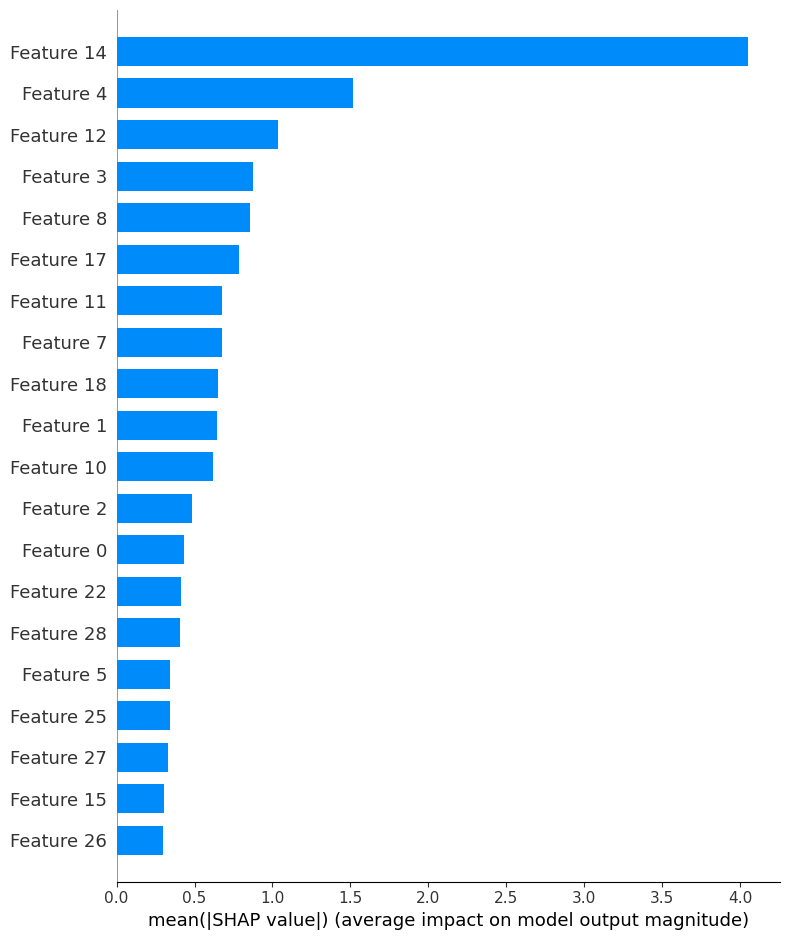

In [ ]:
# SHAP for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type="bar")


shap.force_plot(explainer.expected_value, shap_values[0], X_test[0])


In [18]:
def print_metrics(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.2f}")

print("Logistic Regression:")
print_metrics(y_test, y_pred_lr)

print("\nXGBoost:")
print_metrics(y_test, y_pred_xgb)


Logistic Regression:
Accuracy: 0.95
Precision: 0.97
Recall: 0.92
F1-Score: 0.95

XGBoost:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
